<a href="https://colab.research.google.com/github/Maithraanand/Applied-DL/blob/main/ADL_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_helmet_detection_path = kagglehub.dataset_download('andrewmvd/helmet-detection')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/helmet-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helmet-detection/annotations/BikesHelmets338.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets680.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets62.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets172.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets622.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets477.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets488.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets696.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets71.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets269.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets206.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets705.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets515.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets113.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets546.xml
/kaggle/input/helmet-detection/annotations/BikesHelmets63

Using device: cpu
Epoch 1/25, Loss: 127578.8867
Epoch 2/25, Loss: 583.5036
Epoch 3/25, Loss: 493.0068
Epoch 4/25, Loss: 440.0916
Epoch 5/25, Loss: 408.7461
Epoch 6/25, Loss: 387.8800
Epoch 7/25, Loss: 366.9846
Epoch 8/25, Loss: 349.1299
Epoch 9/25, Loss: 332.2270
Epoch 10/25, Loss: 318.6976
Epoch 11/25, Loss: 298.9029
Epoch 12/25, Loss: 285.9713
Epoch 13/25, Loss: 268.9177
Epoch 14/25, Loss: 254.5385
Epoch 15/25, Loss: 240.8374
Epoch 16/25, Loss: 224.7608
Epoch 17/25, Loss: 215.3152
Epoch 18/25, Loss: 202.9718
Epoch 19/25, Loss: 198.4781
Epoch 20/25, Loss: 192.1888
Epoch 21/25, Loss: 175.4955
Epoch 22/25, Loss: 173.9205
Epoch 23/25, Loss: 159.2857
Epoch 24/25, Loss: 145.9662
Epoch 25/25, Loss: 146.4374


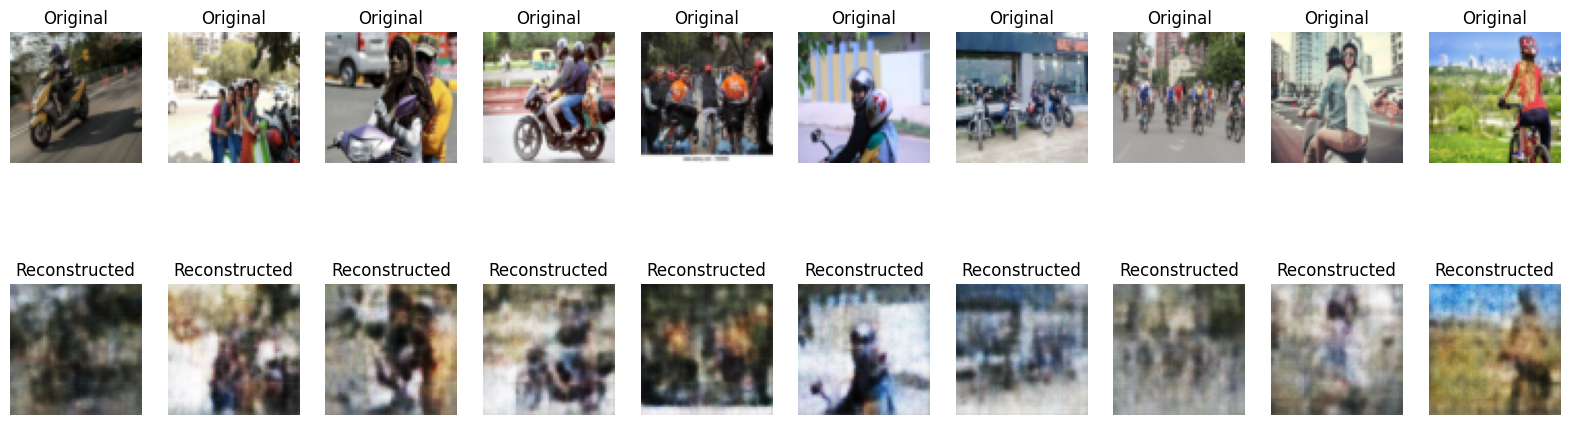

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define directories
dataset_dir = '/kaggle/input/helmet-detection'
images_dir = os.path.join(dataset_dir, 'images')

# Image transform
img_size = 64
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Custom dataset class to load images from 'images' folder
class HelmetDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image

# Load datasets
train_dataset = HelmetDataset(images_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# VAE model definition
latent_dim = 128
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(4 * 4 * 512, latent_dim)  # Mean of latent space
        self.fc_logvar = nn.Linear(4 * 4 * 512, latent_dim)  # Log variance of latent space

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 4 * 4 * 512)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization Trick to Sample Latent Vector"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Sample from normal distribution
        return mu + eps * std  # Reparameterization

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 512, 4, 4)  # Reshape back to image format
        x = self.decoder(x)
        return x, mu, logvar

# Instantiate the model
vae = VAE(latent_dim).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.0001 * kl_loss  # Scaling KL loss to avoid over-regularization

# Training loop
epochs = 25
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for images in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(images)
        loss = vae_loss(reconstructed, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# ----- Evaluate & Predict -----
vae.eval()
with torch.no_grad():
    for images in train_loader:
        images = images.to(device)
        reconstructed, _, _ = vae(images)
        break  # Take only one batch for visualization

# Convert images to numpy
images = images.cpu().numpy().transpose(0, 2, 3, 1)
reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)

# ----- Visualize Results -----
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original Image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    ax.set_title("Original")
    ax.axis("off")

    # Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i])
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.show()
